In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import os
import pandas as pd
from torchvision.models import densenet121
from torchvision.models import alexnet
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/violence-detection')
from convlstm import ConvLSTM



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Train data directory
directory = '/content/drive/MyDrive/data' #modify as needed

In [4]:
# # TESTING THAT A VIDEO CAN BE READ
# # Create a VideoCapture object
# cap = cv2.VideoCapture(directory + '/' + 'Violence' + '/' + 'Violence001.avi')

# # Check if camera opened successfully
# if (cap.isOpened()== False):
#     print("Error opening video file")

# # Read until video is completed
# while(cap.isOpened()):
#     # Capture frame-by-frame
#     ret, frame = cap.read()
#     if ret == True:
#         # Display the resulting frame
#         cv2.imshow('Frame', frame)
#         # Press Q on keyboard to exit
#         if cv2.waitKey(25) & 0xFF == ord('q'):
#             break
#     # Break the loop
#     else:
#         break

# # When everything done, release the video capture object
# cap.release()

# # Closes all the frames
# cv2.destroyAllWindows()

In [5]:
def calculate_optical_flow(video_path, frame_skip=4):
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    prvs = cv2.resize(frame1, (224, 224))
    prvs = cv2.cvtColor(prvs, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros((prvs.shape[0], prvs.shape[1], 3))
    hsv[..., 1] = 255

    optical_flows = []  # list to store optical flow of each frame
    frame_count = 0
    while True:
        ret, frame2 = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % frame_skip != 0:
            continue
        next = cv2.resize(frame2, (224, 224))
        next = cv2.cvtColor(next, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(
            prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv.astype(np.float32), cv2.COLOR_HSV2BGR)
        # normalize
        # bgr = (bgr - bgr.min()) / (bgr.max() - bgr.min())
        optical_flows.append(bgr)  # store optical flow of current frame

        prvs = next

    cap.release()
    return optical_flows  # return list of optical flows

### Loading all videos, transforming them into optical flow representations, storing in memory, and creating a training data loader.

**Now the model is ready to be trained**

In [6]:
Videos = []
labels = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".avi"):  # videos are in .avi format
        video_path = os.path.join(directory, filename)
        # assuming this now returns a list of optical flows
        frame_skip = 4
        resultant_frames = 10
        optical_flows = calculate_optical_flow(video_path, frame_skip = frame_skip)
        if len(optical_flows) < resultant_frames:
          padding = [np.zeros_like(optical_flows[0]) for _ in range(resultant_frames - len(optical_flows))]
          optical_flows = padding + optical_flows
        elif len(optical_flows) > resultant_frames:
          optical_flows = optical_flows[:resultant_frames]
        # transpose each optical flow
        optical_flows = np.stack(
            [np.transpose(flow, (2, 0, 1)) for flow in optical_flows])
        if filename.startswith('fi'):
            Videos.append(optical_flows)
            labels.append(0)
        elif filename.startswith('no'):
            Videos.append(optical_flows)
            labels.append(1)
data = np.array(Videos, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)
# split into train ad test data using sklearn
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42)
# train data
# train_data = torch.tensor(train_data).half()
train_data = torch.tensor(train_data)
train_data = train_data.permute(0, 2, 1, 3, 4)
# print(train_data.shape)
train_labels = torch.tensor(train_labels).long()
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
print(len(train_loader))
print(train_loader.dataset.tensors[0].shape)
# test data
# test_data = torch.tensor(test_data).half()
test_data = torch.tensor(test_data)
test_data = test_data.permute(0, 2, 1, 3, 4)
# print(test_data.shape)
test_labels = torch.tensor(test_labels).long()
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)
print(len(test_loader))
print(test_loader.dataset.tensors[0].shape)
# Save
torch.save(train_loader, '/content/drive/My Drive/train_loader.pth')
torch.save(test_loader, '/content/drive/My Drive/test_loader.pth')

100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


50
torch.Size([800, 3, 10, 224, 224])
12
torch.Size([200, 3, 10, 224, 224])


In [7]:
# train_loader = torch.load('/content/drive/My Drive/train_loader.pth')
# test_loader = torch.load('/content/drive/My Drive/test_loader.pth')
# print(len(train_loader))
# print(len(test_loader))

### DenseNet121 model adapted for video data and ConvLSTM added

In [8]:
model = densenet121(pretrained=True)
torch.autograd.set_detect_anomaly(True)

# DenseBlock 1
new_layers = nn.Sequential()
for i in range(len(model.features.denseblock1)):
    new_layer = nn.Sequential(
    nn.BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False))
    new_layers.add_module(str(i), new_layer)
model.features.denseblock1 = new_layers

# DenseBlock 2
new_layers = nn.Sequential()
for i in range(len(model.features.denseblock2)):
    new_layer = nn.Sequential(
    nn.BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(8, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False))
    new_layers.add_module(str(i), new_layer)
model.features.denseblock2 = new_layers

# DenseBlock 3
new_layers = nn.Sequential()
for i in range(len(model.features.denseblock3)):
    new_layer = nn.Sequential(
    nn.BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(16, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False))
    new_layers.add_module(str(i), new_layer)
model.features.denseblock3 = new_layers

# DenseBlock 4
new_layers = nn.Sequential()
for i in range(len(model.features.denseblock4)):
    new_layer = nn.Sequential(
    nn.BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False))
    new_layers.add_module(str(i), new_layer)
model.features.denseblock4 = new_layers

# Transition Layers
new_layers = nn.Sequential(
    nn.BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(4, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0))
model.features.transition1 = new_layers

new_layers = nn.Sequential(
    nn.BatchNorm3d(8, eps=1e-05, momentum=0.1,
                   affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(8, 16, kernel_size=(1, 1, 1), stride=(
        1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0))
model.features.transition2 = new_layers

new_layers = nn.Sequential(
    nn.BatchNorm3d(16, eps=1e-05, momentum=0.1,
                   affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(
        1, 1, 1), padding=(1, 1, 1), bias=False),
    nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0))
model.features.transition3 = new_layers

# Replace the first four layers
model.features.conv0 = nn.Conv3d(3, 4, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
model.features.norm0 = nn.BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model.features.relu0 = nn.ReLU(inplace=True)
model.features.pool0 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
model.features.norm5 = nn.BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Flatten Layer
model.add_module('flatten', nn.Flatten())
# ConvLSTM Layer
model.add_module('convlstm', ConvLSTM(input_dim=32,
                                      hidden_dim=[4, 4],
                                      kernel_size=(3, 3),
                                      num_layers=2,
                                      batch_first=True,
                                      bias=True,
                                      return_all_layers=False))

# Classification Layer
model.classifier = nn.Linear(2080, 2)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = True

# Unfreeze parameters in ConvLSTM and fc layer
for param in model.convlstm.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**The cell below tests that the model is working as expected**

In [9]:
# Test model on one optical flow example
# test_vid_path = directory + '/' + 'Violence' + '/' + 'Violence001.avi'
test_vid_path = directory + '/' + 'fi8_xvid.avi'
test_optical_flow = calculate_optical_flow(test_vid_path, 4)
# assuming this now returns a list of optical flows
test_optical_flow = np.stack([np.transpose(flow, (2, 0, 1))
                             for flow in test_optical_flow])
# test_optical_flow = torch.tensor(test_optical_flow).half().unsqueeze(0)
test_optical_flow = torch.tensor(test_optical_flow).unsqueeze(0)
test_optical_flow = test_optical_flow.permute(0, 2, 1, 3, 4)
test_optical_flow = test_optical_flow.to(device)
print(test_optical_flow.shape)
torch.cuda.empty_cache()
output = model(test_optical_flow)
print(output.shape)
torch.cuda.empty_cache()

torch.Size([1, 3, 10, 224, 224])
torch.Size([1, 2])


## Training the model

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
lossfun = nn.CrossEntropyLoss()
# number of epochs
numepochs = 250
# create a new model
# initialize losses
losses = []
trainAcc = []
# loop over epochs
for epochi in range(numepochs):
  torch.cuda.empty_cache() # clear cache
  # switch on training mode
  model.train()

  # loop over training data batches
  batchAcc = []
  batchLoss = []
  for X, y in train_loader:
    X = X.to(device)
    y = y.to(device)
    # forward pass and loss
    yHat = model(X)
    # print(yHat.isnan().any())
    loss = lossfun(yHat, y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(loss.item())
    # loss from this batch
    batchLoss.append(loss.item())
    # compute accuracy
    batchAcc.append(
        100*torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    torch.cuda.empty_cache()
  # end of batch loop...

  # now that we've trained through the batches, get their average training accuracy
  trainAcc.append(np.mean(batchAcc))

  # and get average losses across the batches
  losses.append(np.mean(batchLoss))

  print(
      f'Epoch {epochi+1}/{numepochs}, Loss: {losses[-1]}, Accuracy: {trainAcc[-1]}')
# end epochs
# output

Epoch 1/250, Loss: 0.7135077393054963, Accuracy: 56.875
Epoch 2/250, Loss: 0.6722029280662537, Accuracy: 59.75
Epoch 3/250, Loss: 0.653733812570572, Accuracy: 61.0
Epoch 4/250, Loss: 0.6652146589756012, Accuracy: 60.125
Epoch 5/250, Loss: 0.6559000873565674, Accuracy: 61.75
Epoch 6/250, Loss: 0.6324013125896454, Accuracy: 63.125
Epoch 7/250, Loss: 0.6304508596658707, Accuracy: 64.125
Epoch 8/250, Loss: 0.6448772072792053, Accuracy: 62.75
Epoch 9/250, Loss: 0.6366161233186722, Accuracy: 64.25
Epoch 10/250, Loss: 0.6246780610084534, Accuracy: 66.125
Epoch 11/250, Loss: 0.610544559955597, Accuracy: 67.625
Epoch 12/250, Loss: 0.6039233982563019, Accuracy: 68.125
Epoch 13/250, Loss: 0.5986298453807831, Accuracy: 69.375
Epoch 14/250, Loss: 0.5889511644840241, Accuracy: 67.875
Epoch 15/250, Loss: 0.5878440397977829, Accuracy: 69.625
Epoch 16/250, Loss: 0.5784329545497894, Accuracy: 69.625
Epoch 17/250, Loss: 0.5791513508558274, Accuracy: 70.875
Epoch 18/250, Loss: 0.5778335154056549, Accuracy

In [16]:
# # Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/model.pth')

## Testing Model Performance
**If model has been trained (or trained and the model is saved in a pth file), run the cells below**

In [12]:
# # Uncomment this cell only if you have the saved model and wish to load it. Note: model variable must be initialized above before loading the model
# def getSavedModel():
#     model.load_state_dict(torch.load('model.pth'))
#     return model
# model = getSavedModel()


**Get predictions using test data**

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        91
           1       0.54      1.00      0.70       101

    accuracy                           0.55       192
   macro avg       0.77      0.52      0.39       192
weighted avg       0.76      0.55      0.41       192

Accuracy: 0.546875
F1: 0.40759538335458023
Precision: 0.7565658244680851
Recall: 0.546875


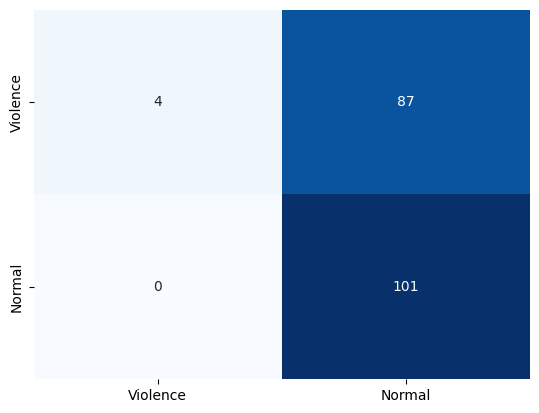

In [13]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
testAcc = []
with torch.no_grad():
    yTrue = []
    yPred = []
    batchAcc = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        batchAcc.append(100*torch.mean((torch.argmax(outputs, axis=1) == labels).float()).item())
        yTrue.extend(labels.cpu().numpy())
        yPred.extend(torch.argmax(outputs, axis=1).cpu().numpy())
    testAcc.append(np.mean(batchAcc))
print(classification_report(yTrue, yPred))
print('Accuracy:', accuracy_score(yTrue, yPred))
print('F1:', f1_score(yTrue, yPred, average='weighted'))
print('Precision:', precision_score(yTrue, yPred, average='weighted'))
print('Recall:', recall_score(yTrue, yPred, average='weighted'))
sns.heatmap(confusion_matrix(yTrue, yPred), annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Violence', 'Normal'], yticklabels=['Violence', 'Normal'])
plt.show()

**Do not run the cell below if you did not train the model prior**

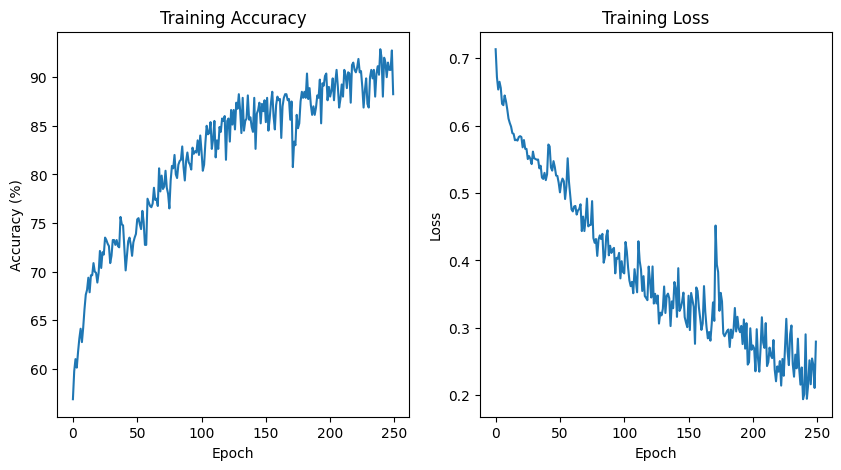

In [15]:
# DO NOT RUN THIS CELL IF YOU LOADED THE MODEL AND DID NOT TRAIN IT AS TRAINACC & LOSSES WILL BE UNDEFINED
# Plot trainAcc and losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(trainAcc)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()